In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

/var/folders/90/hzvrpycd5ds6jx99ygz9bbk00000gn/T/ipykernel_45389/991949033.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [115]:
df = pd.read_csv('dataset.csv')

In [116]:
# sort by commits and insertions

df = df.sort_values(by=['commits', 'insertions'], ascending=False)
df

,project,language,commits,insertions,age,bugs,project_type,devs
636,linux,C,305361,27056685,3199,121302,Middleware,437
683,mono,C#,61113,9087186,4606,23260,Library,439
810,php-src,C,41154,4922903,5401,21848,CodeAnalyzer,299
877,rails,Ruby,28240,1181687,3344,7187,Library,1382
538,homebrew,Ruby,26154,258741,1705,4817,Application,54
...,...,...,...,...,...,...,...,...
1080,vowpal_wabbit,C#,28,1585,1700,10,Other,8
410,eco,Javascript,28,1544,467,2,Framework,2
998,sublime-typescript,Python,28,924,96,12,CodeAnalyzer,3
592,jquery.payment,Coffeescript,28,900,138,5,Library,6


We define the dataset as an xarray aswell, so it fits PyMC.

In [10]:
df_xa = df.to_xarray()

In [11]:
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [12]:
def plot_parameters(trace, features, trace_plot=True, forest_plot=True):
  '''
  Plot parameters from trace. 
  '''
  var_names = list(trace.posterior.data_vars.keys())[:-1]
  if trace_plot:
    az.plot_trace(trace, var_names=var_names)
  if forest_plot:
    az.plot_forest(trace, var_names=var_names, combined=True)

In [13]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

In [14]:
def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## Hypothesis 1

* **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L).

In [15]:
df.groupby('language').size()

language
C                82
C#               51
C++              86
Clojure          50
Coffeescript     52
Erlang           42
Go               38
Haskell          39
Java             74
Javascript      202
Objective-C      56
Perl             25
Php              57
Python          102
Ruby             67
Scala            46
Typescript       58
dtype: int64

Since the outcome variable Bugs $B$ is an unbounded count, we model it with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We treat programming language $L$ as a categorical nominal predictor with 17 levels. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{L[i]}
$$

The priors for $\alpha$ and $\beta_{L[i]}$ are not yet defined. In the following sections we determine reasonable priors for them.
$$
\alpha = \text{Not determined yet}
$$

$$
\beta_{L[i]} = \text{Not determined yet}
$$





#### Determine prior for $\alpha$

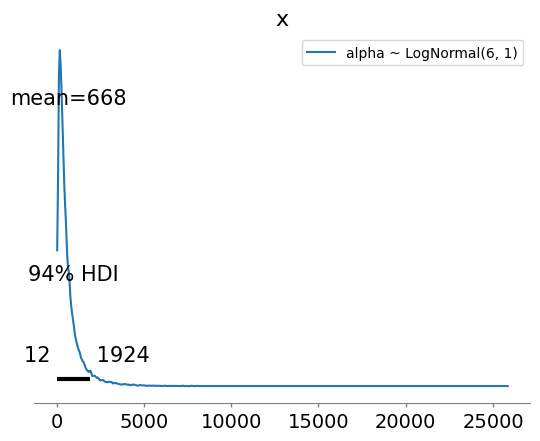

In [16]:
#To find a suitable prior for $\alpha$, we sample from a LogNormal distribution and see whether it produces reasonable values. After some experimentation we settled on the following:

#Maybe this is too fit to the data? 
# az.plot_posterior(
#    pm.draw(pm.LogNormal.dist(6, 1),draws=20_000),
#    label="alpha ~ LogNormal(6, 1)"
# )
# plt.show();

Using the log-link function changes the outcome scale, which in turn has an effect on the priors. We therefore have to be careful when defining the priors, because the outcome scale of the prior is not linear. 

To simulate and explore the effects of possible priors for $\alpha$, we create a model that only contains $\alpha$ and does not include $\beta_{L[i]}$

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

$$
log(\lambda_i) = \alpha 
$$


$$
\alpha = \text{Not determined yet}
$$



In [17]:
def prior_predictive_check_alpha(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lam', pm.math.exp(alpha))
        B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
        trace = pm.sample_prior_predictive(samples=500)
        
    return trace, model

We explore possible values for for $\alpha$

Sampling: [B, alpha]


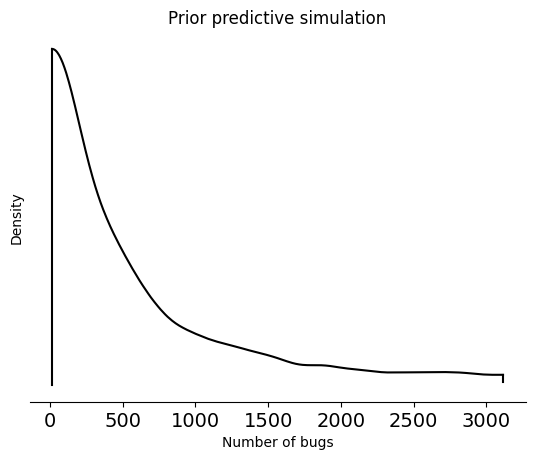

In [18]:
h1_alpha_idata, h1_alpha_model = prior_predictive_check_alpha(6,1.3)

az.plot_density(
    h1_alpha_idata.prior['lam'],
    colors='black',
    point_estimate=None)
plt.title('Prior predictive simulation')
plt.xlabel('Number of bugs')
plt.ylabel('Density');

This  seems like a reasonable prior, since it assigns the 94% HDI of $B$ to be between 10 and 1914 with a mean of 661 bugs.

We therefore define the prior for $\alpha$ to be $\mathrm{Normal}(6, 1)$.

#### Determine prior for $\beta_{L[i]}$ 

Next we determine priors for $\beta_{L[i]}$.  

We simulate the effect of varying the prior for $\beta_{L[i]}$ by sampling N alphas with a fixed prior, and sampling N betas where we can determine the prior.

We then plot the effect only including the intercept $\alpha$ (0) and then including both $\alpha$ and $\beta_{L[i]}$ (1). This creates a line that corresponds to the effect of adding a language as a predictor.

In [24]:
def plot_prior_categorical(b_mean: int = 1, b_std: int = 1, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.1, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    # Plot each line
    for a, b in zip(alphas, betas):
        x_seq = np.array([0, 1])
        plt.plot(x_seq, np.exp(a + b * x_seq), 'k', alpha=0.4)

    plt.xticks([0, 1])
    plt.xlabel("Language")
    plt.yscale("log")
    plt.ylabel('Number of bugs')
    
    return plt


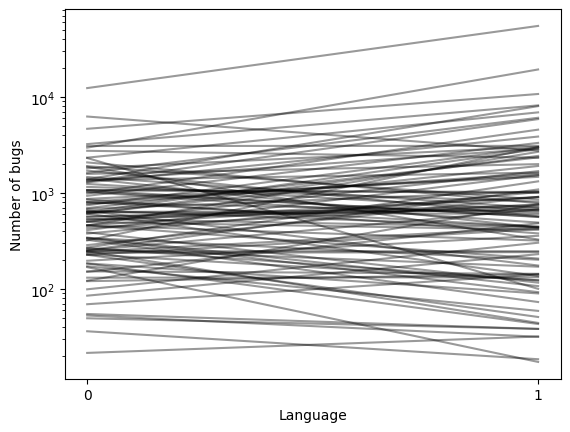

In [25]:
plot_prior_categorical(0, 1);

These effects of language seem plausible. They allow for both positive and negative impact of language on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of language. There are 17 different languages and some of them might have a positive impact on the number of bugs, whereas others might have a negative impact. We want the prior for the effect of language to reflect this, since we only determine a single prior for all languages.


We therefore define the prior for $\beta_{L[i]}$ to be $\mathrm{Normal}(0, 1)$.

#### Fit model

We factorise the language column, so it can fit in the model.

## ANDREAS

In [119]:
df["language"], languages = pd.factorize(df["language"])
test_df = df.groupby("language").aggregate({"bugs":"sum"}).reset_index()

In [91]:
test_df

,language,bugs
0,0,182344
1,1,50646
2,2,30342
3,3,35037
4,4,47119
5,5,79176
6,6,41637
7,7,10326
8,8,12935
9,9,8119


In [96]:
with pm.Model() as model:
      # Priors
      alpha = pm.Normal("alpha", mu=6, sigma=1.3,shape=17)
      beta = pm.Normal('beta',  mu=0, sigma=1, shape=17)

      lam = pm.Deterministic('lam', pm.math.exp(alpha + beta * test_df.language))
      
      B = pm.Poisson('B', mu=lam, observed=test_df.bugs)


      # prior = pm.sample_prior_predictive(samples=500)
      
      #Sample posterior and prior predictive
      trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 108 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


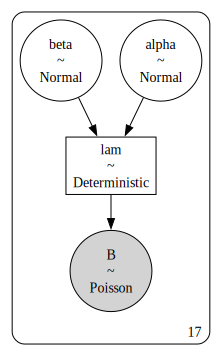

In [97]:
pm.model_to_graphviz(model=model)

In [98]:
pm.summary(trace,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],12.11,0.00,12.11,12.12,0.00,0.00,5032.02,5743.70,1.00
alpha[1],9.07,0.80,7.59,10.60,0.02,0.01,2017.69,3068.15,1.00
alpha[2],7.28,1.11,5.24,9.42,0.02,0.02,2368.85,3352.61,1.00
alpha[3],6.72,1.19,4.47,8.97,0.02,0.02,2639.21,3978.96,1.00
alpha[4],6.44,1.25,4.07,8.76,0.03,0.02,2145.00,3707.13,1.01
alpha[5],6.30,1.25,3.92,8.67,0.03,0.02,2148.73,3589.00,1.00
alpha[6],6.23,1.27,3.92,8.67,0.03,0.02,1889.75,2905.58,1.00
alpha[7],6.08,1.28,3.69,8.50,0.03,0.02,2399.25,3744.90,1.00
alpha[8],6.10,1.29,3.68,8.47,0.03,0.02,2414.37,3983.70,1.00
alpha[9],6.06,1.27,3.74,8.53,0.03,0.02,2374.43,3103.95,1.00


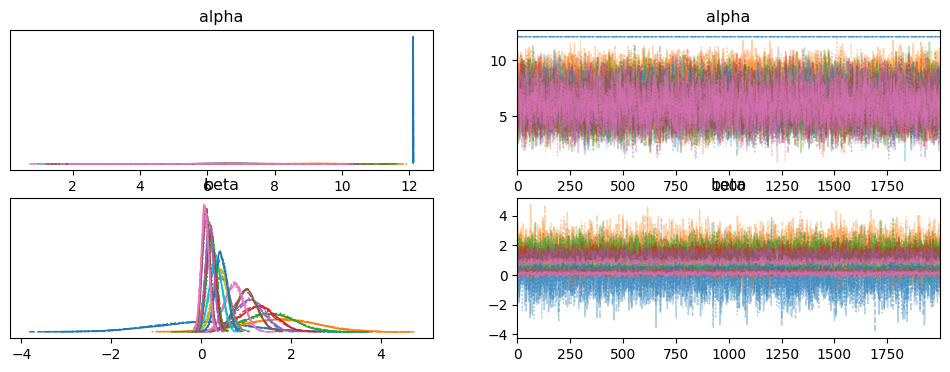

In [99]:
pm.plot_trace(trace, var_names=['alpha','beta']);

In [113]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["lam"])["posterior_predictive"]["lam"]
    
p_mu = np.array(ppc.mean(["chain", "draw"])) #Take mean
p_mu = pd.Series(p_mu, index = languages) #convert to series with same index as languages_mean


Sampling: []


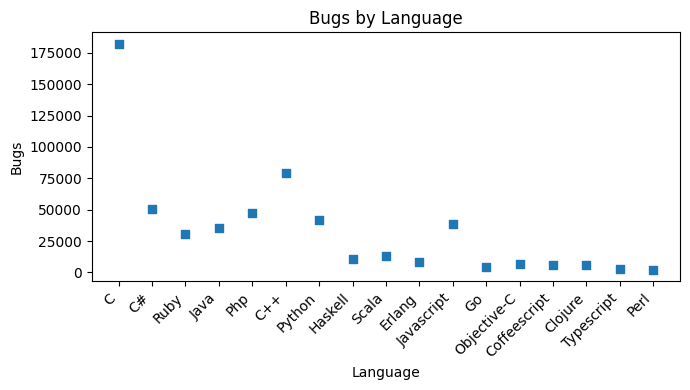

In [120]:
plt.figure(figsize=(7, 4))
# plt.scatter(p_ny´_mean.index, languages_mean, alpha=0.1, marker='o')
plt.scatter(languages[p_mu.index], p_mu, alpha=1, marker='s')
plt.title('Bugs by Language')
plt.xlabel('Language')
plt.ylabel('Bugs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## ANDREAS 

In [103]:
# def create_model_h1(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
#   '''
#   Creates model for hypothesis 1. 
#   '''
#   with pm.Model() as model:
#       # Priors
#       alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior,shape=languages.size)
#       beta = pm.Normal('beta',  mu=beta_mu_prior, sigma=beta_sigma_prior, shape=languages.size)
      
#       #We add language_ids as mutable data so we can change it later in posterior predictions
#       language_ids = pm.Data('language_ids', language_idx, mutable=True)

#       lam = pm.Deterministic('lam', pm.math.exp(alpha + beta[language_ids]))
#       B = pm.Poisson('B', mu=lam, observed=df.bugs,shape=languages.size)
      
#       #Sample posterior and prior predictive
#       trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
#       if save == True:  
#         trace.to_netcdf("./traces/"+save_name+"_.nc")

#   return trace, model

In [77]:
df.head()

,project,language,commits,insertions,age,bugs,project_type,devs,language_ids
636,linux,C,305361,27056685,3199,121302,Middleware,437,0
683,mono,C#,61113,9087186,4606,23260,Library,439,1
810,php-src,C,41154,4922903,5401,21848,CodeAnalyzer,299,0
877,rails,Ruby,28240,1181687,3344,7187,Library,1382,2
538,homebrew,Ruby,26154,258741,1705,4817,Application,54,2


In [78]:
# h1_idata, h1_model = create_model_h1(df, 6, 1.3, 0, 1)

Index(['C', 'C#', 'Ruby', 'Java', 'Php', 'C++', 'Python', 'Haskell', 'Scala',
       'Erlang', 'Javascript', 'Go', 'Objective-C', 'Coffeescript', 'Clojure',
       'Typescript', 'Perl'],
      dtype='object')
Shape.0 Shape.0 17


ValueError: Incompatible Elemwise input shapes [(1127,), (17,)]

We plot the structure of the model below. The model has one $\alpha$ and one $\beta$ for every language (17 total). It also has 1.127 observations of number of bugs (B).

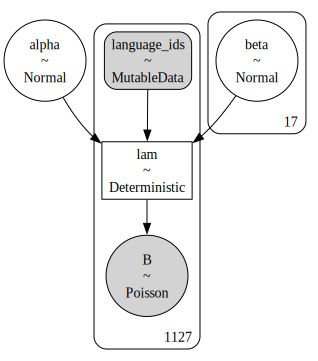

In [29]:
pm.model_to_graphviz(model=h1_model)

**THIS TEXT IS A DRAFT AND NOT CHANGED FOR THE RESULTS**

Below is the trace convergence for the parameters `alpha` and `beta`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [30]:
#specifying names of the variables
var_names_langauge = list(h1_idata.posterior.data_vars.keys())[:-1]
pm.summary(h1_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.60,0.24,5.19,6.06,0.01,0.01,281.16,279.60,1.02
beta[0],2.10,0.24,1.65,2.52,0.01,0.01,281.28,281.09,1.02
beta[1],1.30,0.24,0.84,1.72,0.01,0.01,281.17,280.82,1.02
beta[2],0.51,0.24,0.05,0.93,0.01,0.01,281.14,283.12,1.02
beta[3],0.56,0.24,0.10,0.97,0.01,0.01,281.19,279.92,1.02
beta[4],1.12,0.24,0.66,1.53,0.01,0.01,281.23,280.18,1.02
beta[5],1.22,0.24,0.76,1.64,0.01,0.01,281.19,279.85,1.02
beta[6],0.41,0.24,-0.05,0.83,0.01,0.01,281.06,281.66,1.02
beta[7],-0.02,0.24,-0.49,0.39,0.01,0.01,282.53,283.38,1.02
beta[8],0.04,0.24,-0.42,0.46,0.01,0.01,280.81,287.04,1.02


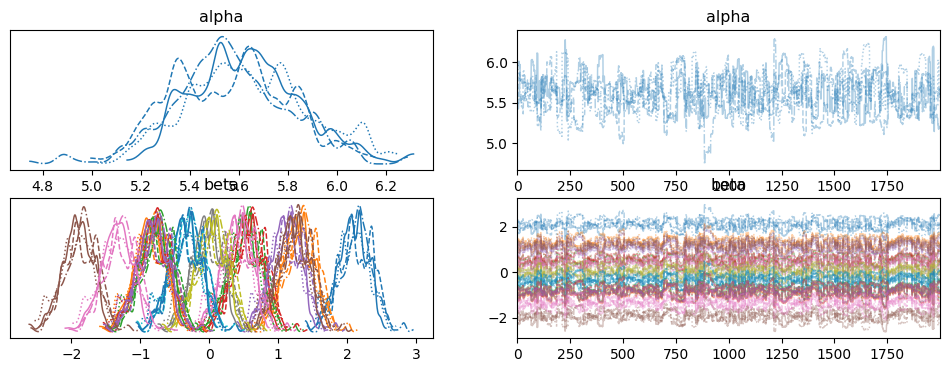

In [31]:
pm.plot_trace(h1_idata, var_names=['alpha','beta']);

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


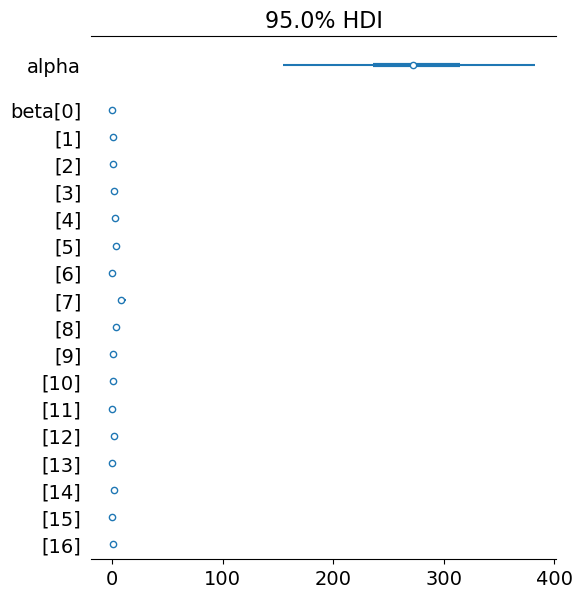

In [397]:
pm.plot_forest(h1_idata, var_names=['alpha','beta'], hdi_prob=.95, combined=True, transform=transform_exp);

#### Posterior Predictive Check

We first compute emperical mean bugs for each langauge.

In [93]:
#Calculate emperical mean of every language. Use for-loop instead of 'groupby' to maintain index order.
languages_mean = []
for language in languages:
    language_mean = df[df['language']==language]['bugs'].mean()
    languages_mean.append(language_mean)
languages_mean = pd.Series(languages_mean, index=languages)

We then calculate posterior predictive checks for each language. 

In [226]:
with h1_model:
    pm.set_data({'language_ids': np.array(range(len(languages)))}) #
    ppc = pm.sample_posterior_predictive(h1_idata, var_names=["lam"])["posterior_predictive"]["lam"]
p_mu = np.array(ppc.mean(["chain", "draw"])) #Take mean
p_mu = pd.Series(p_mu, index=languages) #convert to series with same index as languages_mean

Sampling: []


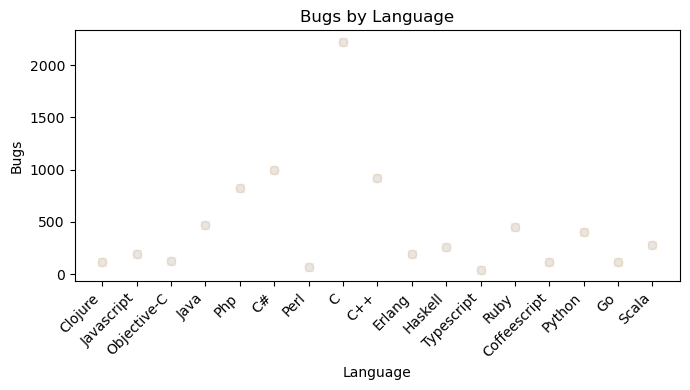

In [343]:
plt.figure(figsize=(7, 4))
plt.scatter(languages_mean.index, languages_mean, alpha=0.1, marker='o')
plt.scatter(languages_mean.index, p_mu, alpha=0.1, marker='s')
plt.scatter
plt.title('Bugs by Language')
plt.xlabel('Language')
plt.ylabel('Bugs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Hypothesis 2

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

Like in **H1** We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We use standardized Age $A$ as a continious predictor. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$

We re-use the prior for $\alpha$ that we determined in **H1**.

$$
\alpha \sim \mathrm{Normal}(6, 1)
$$

We determine the prior for $\beta_{A}$ in the following section.

$$
\beta_{A} = \text{Not determined yet}
$$

We use standardized age, which makes the coefficients easier to interpret. 

In [587]:
df['age_std'] = standardize_column(df['age'])

#### Determine prior for $\beta_A$ 

Next we determine priors for $\beta_{A}$.  

We simulate the effect of varying the prior for $\beta_{A}$ by sampling N alphas with a fixed prior, and sampling N betas where we can determine the prior.

We then plot the effect of $\beta_{A}$ by varying standardized age from -3 to 3, corresponding to 3 standard deviations below and above the mean of age. We can then see how strong or not strong the prior effect of $\beta_{A}$ is.

In [358]:
#Inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb
#Would be nice to make this work for unstandardized age aswell

def plot_prior_continious(b_mean: int = 0, b_std: int = 0, N: int = 100,  ax1=None, ax2=None):
    if ax1 is None:
        _, ax1 = plt.subplots()
        ax1.set_ylabel("Number of bugs")
    #if ax2 is None:
    #    _, ax2 = plt.subplots()
    #    ax2.set_ylabel("Number of bugs")
        
    alphas = np.random.normal(6, 1, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    #x_seq = np.linspace(0, 16000, N) # on normal scale
    
    for a, b in zip(alphas, betas):
        ax1.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    ax1.set_xlabel("Age (std)")
    
    #Use for non-std age if it will work
    #for a, b in zip(alphas, betas):
    #    ax2.plot(x_seq, np.exp(a + b * x_seq), "k", alpha=0.4)
    #ax2.set_xlabel("Age")
    
    return ax1

<Axes: xlabel='Age (std)', ylabel='Number of bugs'>

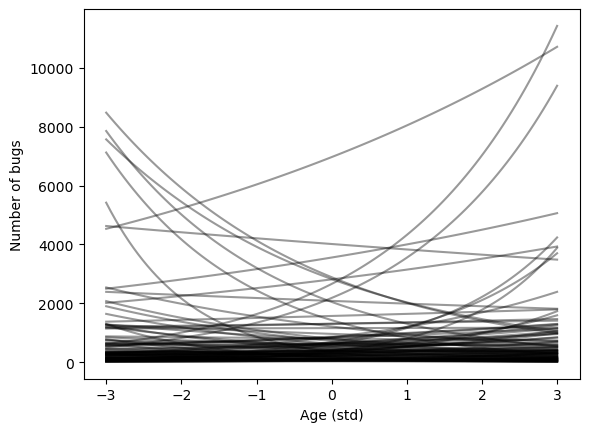

In [359]:
plot_prior_continious(.01, .3)

These effects of age seem plausible. They allow for both positive and negative impact of age on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of age.  


We determine the prior to be $\beta_A \sim \mathrm{Normal}(0.01, 0.3)$

#### Fit model

In [386]:
def create_model_h2(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [387]:
h2_idata, h2_model = create_model_h2(6, 1, 0.01, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.


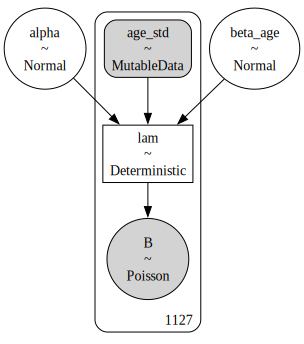

In [623]:
pm.model_to_graphviz(h2_model)

Below is the trace convergence for the parameters `alpha` and `beta_age`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [388]:
pm.summary(h2_idata, var_names=['alpha', 'beta_age'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.08,0.0,6.08,6.09,0.0,0.0,6333.35,5631.81,1.0
beta_age,0.34,0.0,0.34,0.34,0.0,0.0,6774.30,5661.09,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>]], dtype=object)

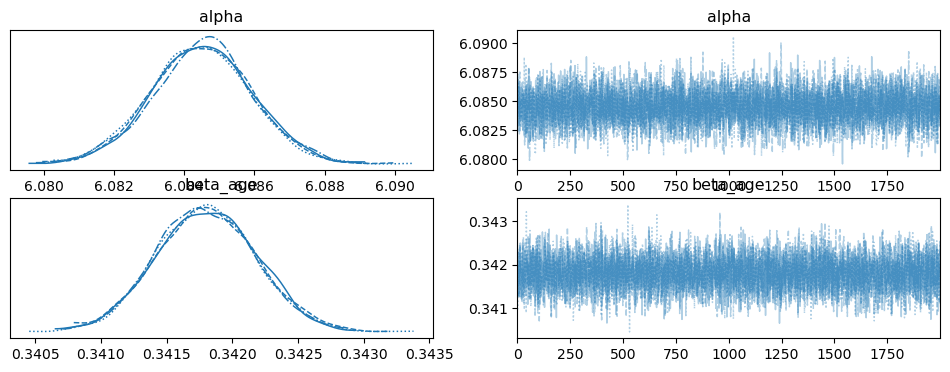

In [389]:
az.plot_trace(h2_idata, var_names = ['alpha','beta_age'])

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


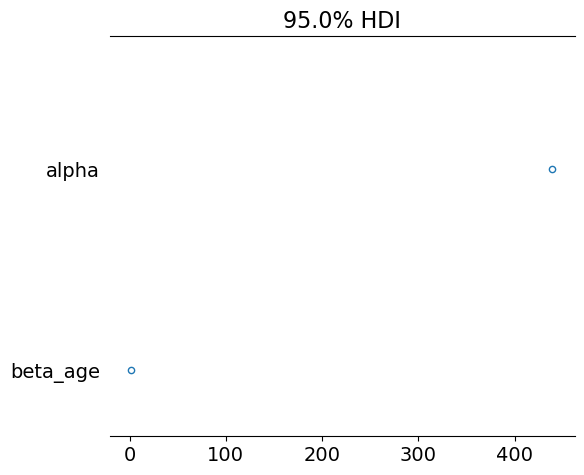

In [391]:
az.plot_forest(h2_idata, var_names = ['alpha','beta_age'], hdi_prob=.95, combined=True, transform=transform_exp);

#### Posterior Predictive Check

We calculate pareto k values for the data-points, to see influential data-points.

In [406]:
pareto_k = az.loo(h2_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [482]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

In [521]:
with h2_model:
    pm.set_data({"age_std": x_seq})
    post_pred_lam_h2 = pm.sample_posterior_predictive(h2_idata, var_names=["lam"])['posterior_predictive']['lam']
    
post_pred_lam_h2_mean = post_pred_lam_h2.mean(["chain", "draw"])

Sampling: []


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0, 0.5, 'Number of bugs')

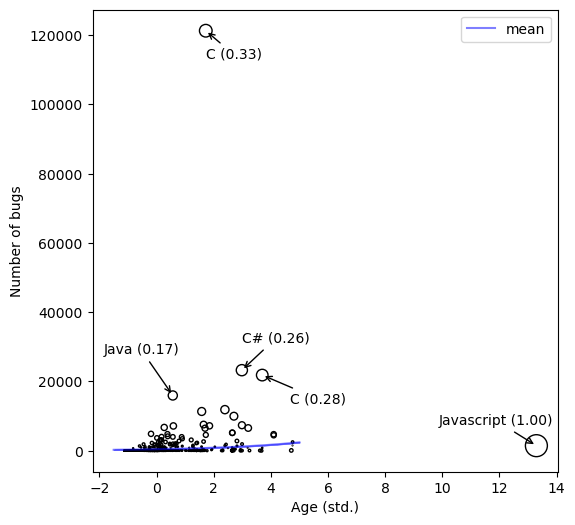

In [522]:
plt.figure(figsize=(6,6))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k /= pareto_k.max()
pareto_k_size = 250 * pareto_k

#Get the 5 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k)[-5:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.5, label='mean')
plt.scatter(df.age_std, df.bugs, s = pareto_k_size, facecolors='none', edgecolors='k', lw=1)


#Plotting text for data points with high pareto-k values
for index, row in top_data_points.iterrows():
    if row['language'] == 'C' and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 'Javascript':
        position=(-70,15)
    elif row['language'] == 'C#':
        position=(0,20)
    elif row['language'] == 'C' and row['project'] == 'php-src':
        position=(20,-20)
    elif row['language'] == 'Java':
        position=(-50,30)
    plt.annotate(f"{row['language']} ({pareto_k[index]:.2f})", xy=(row['age_std'], row['bugs']), xytext=position,
                 textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))


plt.legend()
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')

Text(0, 0.5, 'Number of bugs')

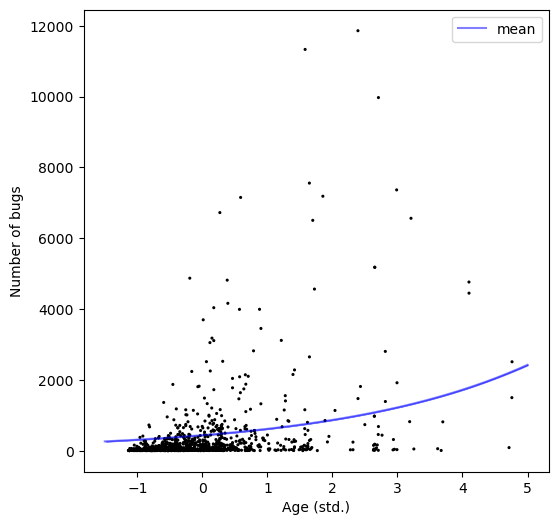

In [524]:
plt.figure(figsize=(6,6))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k /= pareto_k.max()
pareto_k_size = 250 * pareto_k

#Get the 5 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k)[-5:][::-1]
top_data_points = df.iloc[top_indices]

df_without_top5 = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.5, label='mean')
plt.scatter(df_without_top5.age_std, df_without_top5.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)


plt.legend()
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')

## Hypothesis 3

As before we model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We use standardized Age $A$ and standardized commits $C$ as a continious predictors. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i + \beta_{C}C_i
$$

We re-use the priors that we determined in **H2**. We use the same priors for $\beta_C$ as for $\beta_A$.

$$
\alpha \sim \mathrm{Normal}(6, 1)
$$

$$
\beta_A \sim \mathrm{Normal}(0.01, 0.3)
$$

$$
\beta_C \sim \mathrm{Normal}(0.01, 0.3)
$$

We use standardized commits, which makes the coefficients easier to interpret, and also allows us to use the same prior as for $\beta_A$ 

In [492]:
df['commits_std'] = standardize_column(df['commits'])

In [498]:
def create_model_h3(alpha_mu_prior, alpha_sigma_prior, beta_age_mu_prior, beta_age_sigma_prior, beta_com_mu_prior, beta_com_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 3. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_age_mu_prior, sigma=beta_age_sigma_prior)
    beta_com = pm.Normal('beta_com', mu=beta_com_mu_prior, sigma=beta_com_sigma_prior)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    com_std = pm.Data("com_std", df.commits_std, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_age*age_std + beta_com*com_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [499]:
h3_idata, h3_model = create_model_h3(6, 1, 
                                     0.01, 0.3,
                                     0.01, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_com]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.


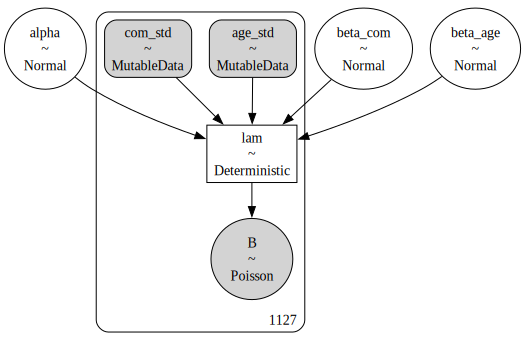

In [506]:
pm.model_to_graphviz(h3_model)

**ALSO A DRAFT**

Below is the trace convergence for the parameters `alpha` and `beta_age`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [501]:
pm.summary(h3_idata, var_names=['alpha', 'beta_age', 'beta_com'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.82,0.0,5.81,5.82,0.0,0.0,4989.19,5487.97,1.0
beta_age,0.33,0.0,0.33,0.33,0.0,0.0,7128.33,6121.86,1.0
beta_com,0.17,0.0,0.17,0.17,0.0,0.0,5992.13,5726.88,1.0


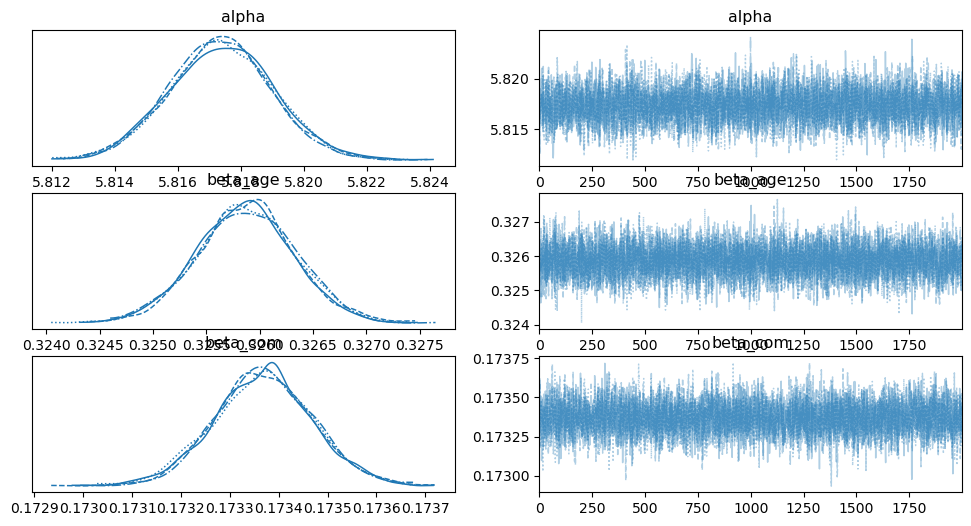

In [504]:
az.plot_trace(h3_idata, var_names = ['alpha','beta_age', 'beta_com']);

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


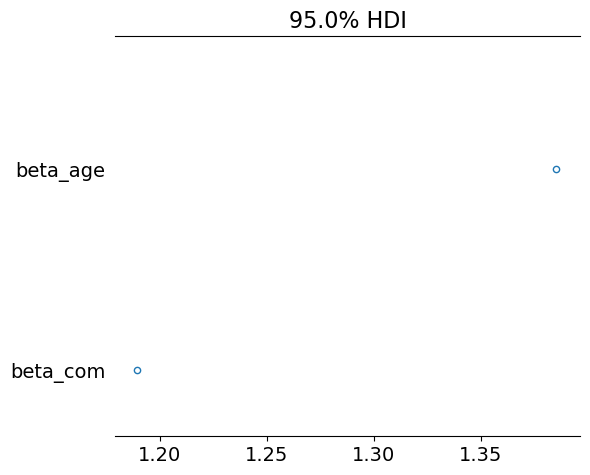

In [533]:
az.plot_forest(h3_idata, var_names = ['beta_age', 'beta_com'], hdi_prob=.95, combined=True, transform=transform_exp);

Next we compare the effect of age on number of bugs without conditioning on the number of commits (H2) and with conditioning on the number of commits (H3). 

We see a notable difference betwen the effect of age in the two models. The effect of age on the number of bugs conditioned by the number of commits is confidently lower than the direct effect of age. 

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

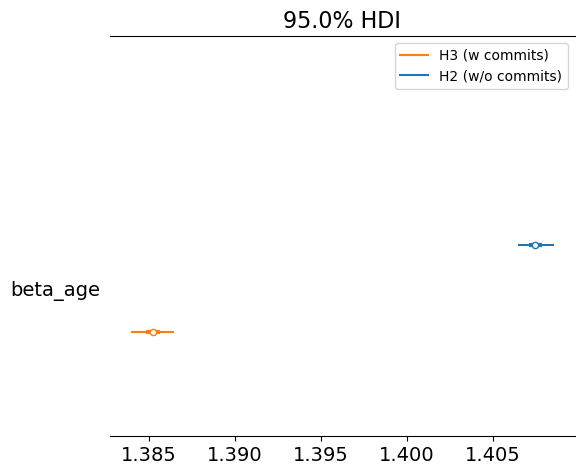

In [511]:
az.plot_forest(
    data=[h2_idata, h3_idata],
    model_names = ['H2 (w/o commits)','H3 (w commits)'],
    var_names=['beta_age'],
    hdi_prob=.95,
    combined=True,
    transform=transform_exp
)

#### Posterior Predictive Check

We calculate pareto k values for the data-points, to see influential data-points.

In [500]:
pareto_k = az.loo(h3_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [542]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)
min_commits_std = df['commits_std'].min() # I dont know if this is correct?

with h3_model:
    pm.set_data({"age_std": x_seq, "com_std": np.repeat(min_commits_std, n_points)})
    post_pred_lam_h3 = pm.sample_posterior_predictive(h3_idata, var_names=["lam"])['posterior_predictive']['lam']
    
post_pred_lam_h3_mean = post_pred_lam_h3.mean(["chain", "draw"])

Sampling: []


Text(0, 0.5, 'Number of bugs')

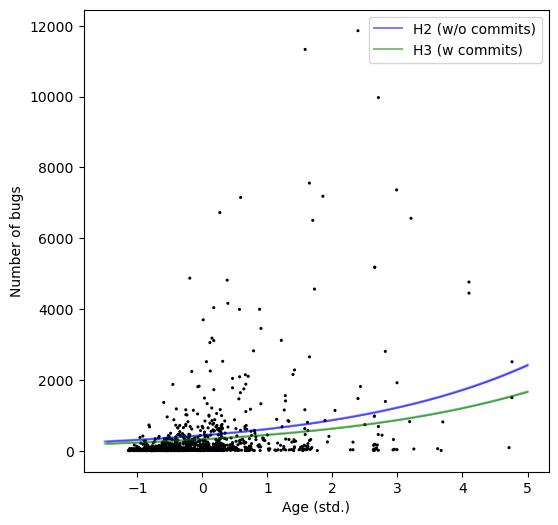

In [545]:
#I dont know if this plot is correct
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.5, label='H2 (w/o commits)')

az.plot_hdi(x_seq, post_pred_lam_h3, color = 'g', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h3_mean, color = 'g', alpha=0.5, label='H3 (w commits)')

plt.scatter(df_without_top5.age_std, df_without_top5.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')

## Use information criteria to compare the models to analyze H1, H2 and H3.

In [554]:
pm.compare({'h1': h1_idata,
            'h2': h2_idata,
            'h3': h3_idata})

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\si

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
h3,0,-5.299586e+05,3563.121498,0.000000,0.333333,73022.582593,0.000000,True,log
h1,1,-1.043340e+06,14516.608922,513381.391889,0.333333,375851.819851,367365.280831,True,log
h2,2,-1.119919e+06,4384.863422,589960.770823,0.333333,497827.505172,489656.688096,True,log


## Multilevel Model

In [575]:
df.groupby('project_type')['bugs'].mean()

project_type
Application      301.995146
CodeAnalyzer     361.913043
Database         394.682540
Framework        443.934169
Library          412.577869
Middleware      2034.457143
Other            489.206897
Name: bugs, dtype: float64

In [602]:
project_types_idx, project_types = pd.factorize(df.project)

In [604]:
def create_model_h2_nopooling(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior, shape=project_types.size)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std and project_types_ids here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    project_types_ids = pm.Data('project_types_idx', project_types_idx, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha[project_types_ids] + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [605]:
h2_nopooling_idata, h2_nopooling_model = create_model_h2_nopooling(6, 1, 0.01, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 284 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


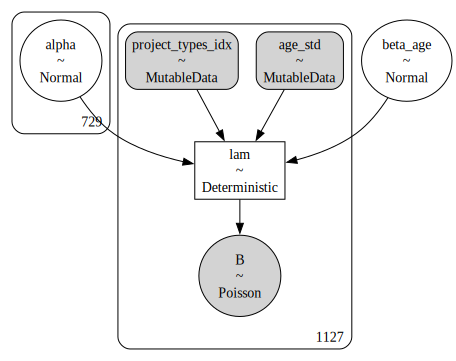

In [606]:
pm.model_to_graphviz(model=h2_nopooling_model)

In [607]:
pm.summary(h2_nopooling_idata, var_names=['alpha', 'beta_age'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],9.86,0.08,9.70,10.01,0.0,0.0,7211.82,5280.02,1.00
alpha[1],13.10,0.13,12.86,13.33,0.0,0.0,5907.08,5477.45,1.00
alpha[2],9.07,0.05,8.97,9.16,0.0,0.0,6011.06,5756.74,1.00
alpha[3],14.63,0.13,14.38,14.88,0.0,0.0,3122.25,4542.04,1.00
alpha[4],8.97,0.08,8.82,9.12,0.0,0.0,10825.84,5439.69,1.00
...,...,...,...,...,...,...,...,...,...
alpha[725],4.09,0.02,4.06,4.13,0.0,0.0,199.99,1119.45,1.03
alpha[726],11.44,0.06,11.33,11.57,0.0,0.0,1132.54,4111.75,1.01
alpha[727],6.81,0.07,6.67,6.95,0.0,0.0,12430.92,4954.32,1.00
alpha[728],9.93,0.34,9.31,10.56,0.0,0.0,12409.26,5424.47,1.00


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


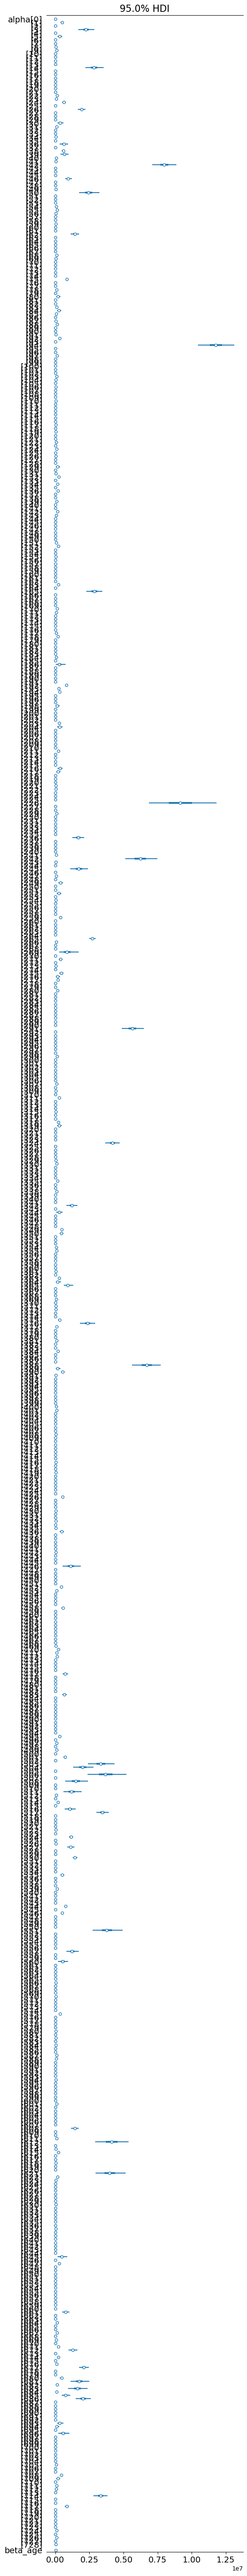

In [608]:
az.plot_forest(h2_nopooling_idata, var_names = ['alpha','beta_age'], hdi_prob=.95, combined=True, transform=transform_exp);

In [610]:
def create_model_h2_multilevel(beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  with pm.Model() as model:
    #Hyperpriors
    alpha_sigma_prior = pm.Exponential('alpha_sigma_prior', lam=1)
    alpha_mu_prior = pm.Normal('alpha_mu_prior', mu=0.01, sigma=1)  
      
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior, shape=project_types.size)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std and project_types_ids here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    project_types_ids = pm.Data('project_types_idx', project_types_idx, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha[project_types_ids] + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [611]:
h2_multilevel_idata, h2_multilevel_model = create_model_h2_multilevel(6, 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_sigma_prior, alpha_mu_prior, alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1681 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


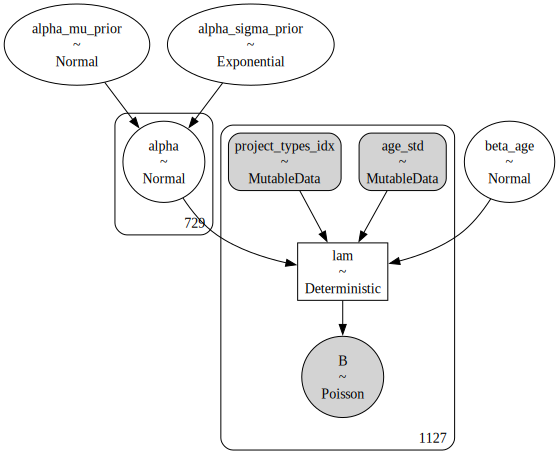

In [612]:
pm.model_to_graphviz(model=h2_multilevel_model)

In [621]:
pm.summary(h2_multilevel_idata, var_names=['alpha', 'beta_age', 'alpha_sigma_prior', 'alpha_mu_prior'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],18.29,0.36,17.79,18.98,0.17,0.13,4.74,17.10,2.56
alpha[1],28.33,0.65,27.42,29.52,0.32,0.24,4.66,15.96,2.71
alpha[2],14.31,0.23,13.99,14.73,0.11,0.08,4.75,16.65,2.56
alpha[3],32.70,0.77,31.66,34.12,0.37,0.29,4.62,14.20,2.79
alpha[4],15.67,0.29,15.24,16.22,0.14,0.11,4.87,19.44,2.40
...,...,...,...,...,...,...,...,...,...
alpha[727],10.63,0.18,10.36,10.97,0.08,0.06,5.32,23.09,2.03
alpha[728],24.62,0.67,23.54,25.92,0.30,0.23,5.48,25.24,1.95
beta_age,29.20,0.78,28.17,30.58,0.38,0.29,4.46,14.17,3.18
alpha_sigma_prior,25.62,1.00,23.88,27.58,0.37,0.27,7.60,32.60,1.48


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


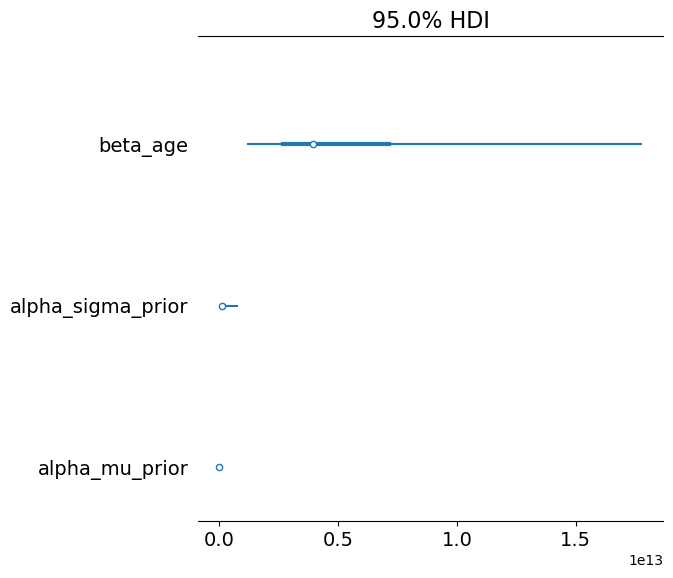

In [622]:
az.plot_forest(h2_multilevel_idata, var_names=['beta_age', 'alpha_sigma_prior', 'alpha_mu_prior'], hdi_prob=.95, combined=True, transform=transform_exp);